In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
import re
import numpy as np

In [3]:
dataframe = pd.read_csv('./data/IMDB_Dataset.csv', lineterminator='\n');
testframe = dataframe.tail(3750)
middle = len(dataframe) // 4
dataframe = dataframe.iloc[:middle]

In [4]:
dataframe.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [5]:
dataframe.shape

(12500, 2)

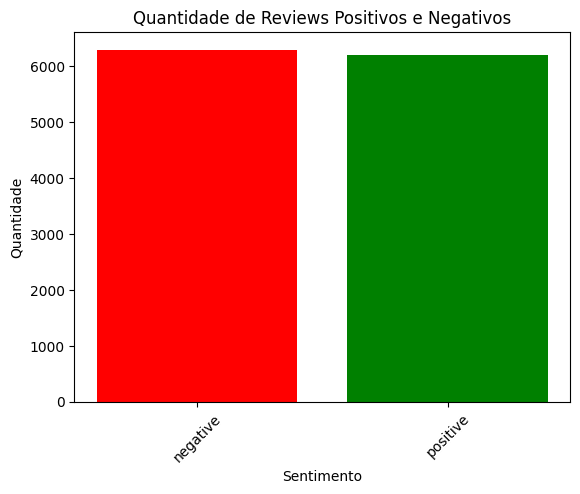

In [19]:
sentiment_count = dataframe['sentiment'].value_counts()
plt.bar(sentiment_count.index, sentiment_count.values, color=['red', 'green'])
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.title('Quantidade de Reviews Positivos e Negativos')
plt.xticks(rotation=45)
plt.show()

In [7]:
dataframe['sentiment'].value_counts()

sentiment
negative    6295
positive    6205
Name: count, dtype: int64

In [16]:
punctuation = string.punctuation
stop_words = STOP_WORDS

nlp = spacy.load('en_core_web_sm')

In [17]:
nlp = spacy.load('en_core_web_sm')

def text_preprocessing(text: string):
    clean_text = re.sub(r'<.*?>', '', text).lower()
    document = nlp(clean_text)
    words = []

    for token in document:
        words.append(token.lemma_)

    words = [word for word in words if word not in stop_words and word not in punctuation]
    words = ' '.join([str(element) for element in words if not element.isdigit()])

    return words

In [20]:
%%time
dataframe['review'] = dataframe['review'].apply(text_preprocessing)

CPU times: total: 10min 18s
Wall time: 11min 11s


In [19]:
dataframe.head()

review sentiment
0  reviewer mention watch oz episode hook right e...  positive
1  wonderful little production film technique una...  positive
2  I think wonderful way spend time hot summer we...  positive
3  basically family little boy jake think zombie ...  negative
4  petter mattei love time money visually stunnin...  positive

In [ ]:
%%time
testframe['review'] = testframe['review'].apply(text_preprocessing)

In [21]:
from matplotlib.colors import ListedColormap
color_map = ListedColormap(['orange', 'green', 'red', 'magenta'])

### Nuvem de palavras (reviews positivos)

In [22]:
from wordcloud import WordCloud
positive_cloud = WordCloud(background_color='white', max_words = 100, colormap = color_map)

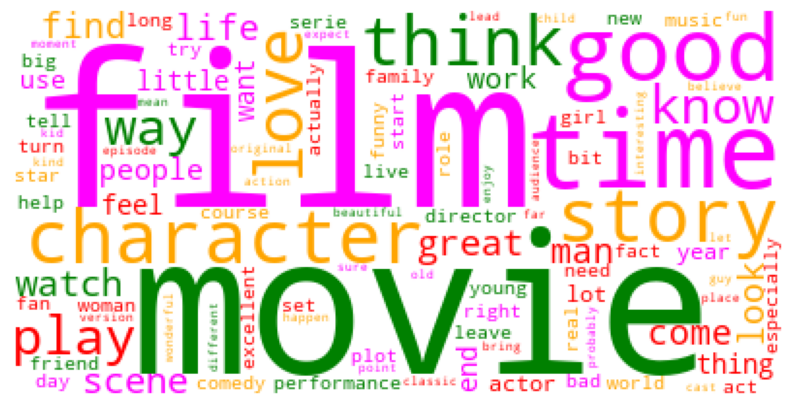

In [31]:
dataframe_positive_reviews = dataframe[dataframe['sentiment'] == 'positive']['review']
positive_reviews = ''
for text in dataframe_positive_reviews:
    positive_reviews += text
positive_cloud = positive_cloud.generate(positive_reviews)
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud)
plt.axis('off')
plt.show()

### Nuvem de palavras (reviews negativos)

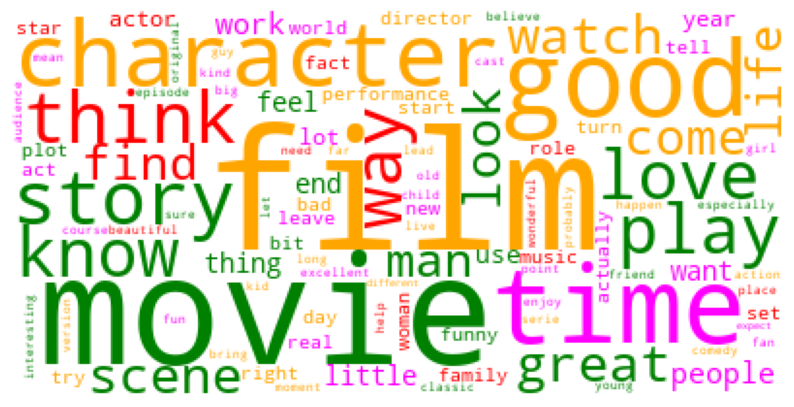

In [30]:
negative_cloud = WordCloud(background_color='white', max_words = 100, colormap = color_map)

dataframe_negative_reviews = dataframe[dataframe['sentiment'] == 'negative']['review']
negative_reviews = ''
for text in dataframe_negative_reviews:
    negative_reviews += text
negative_cloud = negative_cloud.generate(negative_reviews)
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud)
plt.axis('off')
plt.show()

### Adicionando dicionário ao dataset

In [35]:
final_database = []
for review, sentiment in zip(dataframe['review'], dataframe['sentiment']):
    if sentiment == 'positive':
        dict = ({'cats': {'POSITIVE': True, 'NEGATIVE': False}})
    else:
        dict = ({'cats': {'POSITIVE': False, 'NEGATIVE': True}})

    final_database.append([review, dict.copy()])

In [101]:
test_database = []
for review, sentiment in zip(testframe['review'], testframe['sentiment']):
    if sentiment == 'positive':
        dict = ({'cats': {'POSITIVE': True, 'NEGATIVE': False}})
    else:
        dict = ({'cats': {'POSITIVE': False, 'NEGATIVE': True}})

    test_database.append([review, dict.copy()])

In [36]:
len(final_database)

12500

In [37]:
final_database[3]

['basically family little boy jake think zombie closet parent fight time.this movie slow soap opera ... suddenly jake decide rambo kill zombie.ok film decide thriller drama drama movie watchable parent divorce argue like real life jake closet totally ruin film I expect boogeyman similar movie instead I watch drama meaningless thriller spots.3 play parent descent dialog shot jake ignore',
 {'cats': {'POSITIVE': False, 'NEGATIVE': True}}]

In [38]:
model = spacy.blank('en')
textcat = model.add_pipe("textcat")
textcat.add_label('POSITIVE')
textcat.add_label('NEGATIVE')
historic = []
textcat.labels

('POSITIVE', 'NEGATIVE')

### Dividindo dataset em treino (70%) e teste (30%)

In [79]:
train_data, test_data = train_test_split(final_database, test_size=0.3)

In [80]:
len(train_data)

8750

In [81]:
len(test_data)

3750

In [82]:
processed_train_data = []
for text, annotations in train_data:
    doc = model.make_doc(text)
    example = spacy.training.Example.from_dict(doc, annotations)
    processed_train_data.append(example)

In [83]:
historic = [
    {'textcat': 19.25365011394024},
{'textcat': 1.145157779174042},
{'textcat': 0.46899634574894833},
{'textcat': 0.2893492389972181},
{'textcat': 0.2521509494112936},
{'textcat': 0.21016845577538112},
{'textcat': 0.17887443895625998},
{'textcat': 0.06666137984022608},
{'textcat': 0.10583639194659655},
{'textcat': 0.0986342873231178},
{'textcat': 0.18770314811964894},
{'textcat': 0.13108967613831674},
{'textcat': 0.10516629034280278},
{'textcat': 0.03099504524359359},
{'textcat': 0.07821332373892442},
{'textcat': 0.026267350524070365}
]

### Inicia treinamento do modelo

In [19]:
%%time

model.begin_training()
batch_size = 100

for era in range(400):
    random.shuffle(processed_train_data)
    losses = {}

    for batch_start in range(0, len(processed_train_data), batch_size):
        batch = processed_train_data[batch_start:batch_start + batch_size]
        model.update(batch, drop=0.3, losses=losses)
    if era % 25 == 0:
        print(losses)
        historic.append(losses)

{'textcat': 19.25365011394024}
{'textcat': 1.145157779174042}
{'textcat': 0.46899634574894833}
{'textcat': 0.2893492389972181}
{'textcat': 0.2521509494112936}
{'textcat': 0.21016845577538112}
{'textcat': 0.17887443895625998}
{'textcat': 0.06666137984022608}
{'textcat': 0.10583639194659655}
{'textcat': 0.0986342873231178}
{'textcat': 0.18770314811964894}
{'textcat': 0.13108967613831674}
{'textcat': 0.10516629034280278}
{'textcat': 0.03099504524359359}
{'textcat': 0.07821332373892442}
{'textcat': 0.026267350524070365}
CPU times: total: 5h 21min 51s
Wall time: 5h 34min 28s


In [22]:
model.to_disk('trained_model')

In [84]:
historic_loss = []
for i in historic:
    historic_loss.append(i.get('textcat'))

In [85]:
historic_loss = np.array(historic_loss)

In [86]:
historic_loss

array([19.25365011,  1.14515778,  0.46899635,  0.28934924,  0.25215095,
        0.21016846,  0.17887444,  0.06666138,  0.10583639,  0.09863429,
        0.18770315,  0.13108968,  0.10516629,  0.03099505,  0.07821332,
        0.02626735])

Text(0, 0.5, 'Taxa de erro')

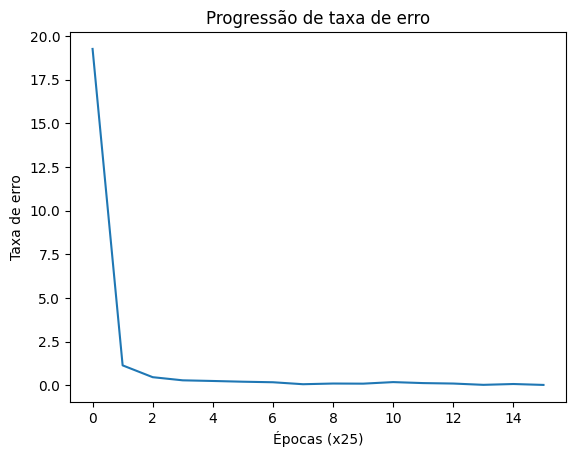

In [87]:
import matplotlib.pyplot as plt
plt.plot(historic_loss)
plt.title('Progressão de taxa de erro')
plt.xlabel('Épocas (x25)')
plt.ylabel('Taxa de erro')

## Teste com review negativo

In [88]:
loaded_model = spacy.load('trained_model')
loaded_model

In [92]:
test1 = test_data[1]
test1[1]

{'cats': {'POSITIVE': False, 'NEGATIVE': True}}

In [93]:
negative_text = test1[0]
negative_text

'state ludicrously horrible movie film bad funny way painful try endure waste time.erika eleniak pretty hot scene bathtub wrap cover breast bubble fat.the fight scene bad unwatchable know care martial art decent choreography editing effect abysmal.there payoff suck'

In [94]:
predict = loaded_model(negative_text)
predict.cats

{'POSITIVE': 1.0087103419209598e-06, 'NEGATIVE': 0.9999990463256836}

## Teste com review positivo

In [71]:
positive_text = test_data[3]
positive_text[0]

'movie incredible piece work explore nook cranny human mind focus character relationship people stellar performance I weep half hour straight spend real time'

In [72]:
positive_text[1]

{'cats': {'POSITIVE': True, 'NEGATIVE': False}}

In [73]:
predict_p = loaded_model(positive_text[0])
predict_p.cats

{'POSITIVE': 0.9999979734420776, 'NEGATIVE': 1.9698552478075726e-06}

## Avaliação do modelo

In [102]:
test_predicts = []
for text, sentiment in test_database:
    predict = loaded_model(text)
    test_predicts.append(predict.cats)

In [103]:
feeling_answer = []
for text, sentiment in test_database:
    if sentiment['cats']['POSITIVE'] > sentiment['cats']['NEGATIVE']:
        feeling_answer.append('positive')
    else:
        feeling_answer.append('negative')

In [104]:
test_predicts_sentiments = []
for sentiment in test_predicts:
    if sentiment['POSITIVE'] > sentiment['NEGATIVE']:
        test_predicts_sentiments.append('positive')
    else:
        test_predicts_sentiments.append('negative')

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(feeling_answer, test_predicts_sentiments)

0.8266666666666667

### Gerando matriz de confusão

In [106]:
cm = confusion_matrix(feeling_answer, test_predicts_sentiments)
cm

array([[1682,  216],
       [ 434, 1418]], dtype=int64)

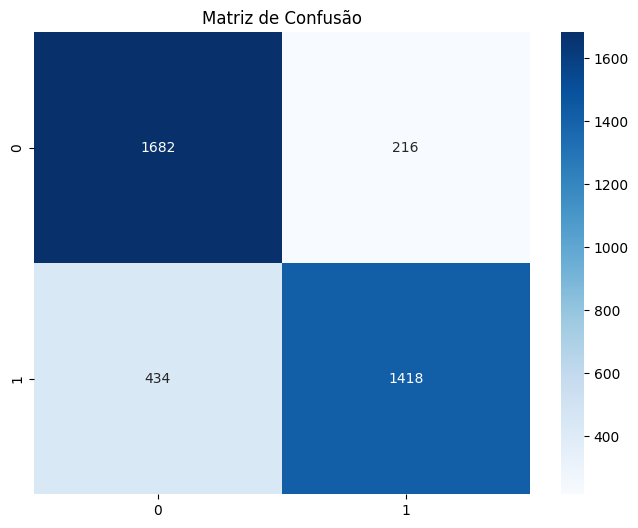

In [108]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()